## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob
import math
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io



def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    ii=0
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl,ii)
        #break
        errs.append(errors)
        confs.append(confidence)
        ii+=1
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, fs, low=40/60, high=240/60):
    """
    Bandpasses a signal in a required range,dropping frequencies outside the given range
    Args:
        signal:signal to be bandpassed
        fs: sampling frequency
    Returns:
        Bandpassed signal
    """
    b, a = sp.signal.butter(3,(low, high), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def spectrogram(signal,fs):
    """
    Spectrogram of a signal
    Args:
        signal: input signal
        fs: sampling frequency
    Returns:
        frequencies(1D) and the corresponding spectrum values (2D)
    """
    spec,freq,_,_= plt.specgram(signal,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(signal)/60/fs])   
    return spec,freq


### Plots of the individual signals for the complete duration of 5min

In [3]:
data_fls, ref_fls = LoadTroikaDataset()
ref_fl = ref_fls[5]
data_fl=data_fls[5]        
len(data_fls)

12

Text(0.5,1,'Acc_z')

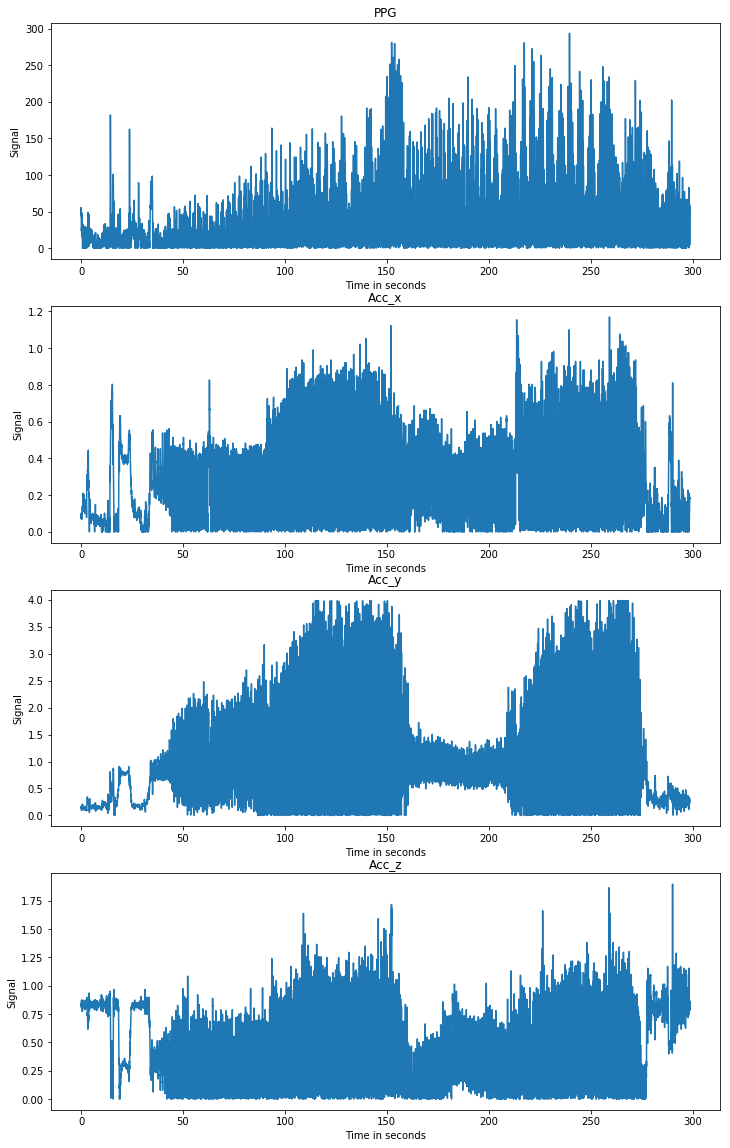

In [4]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
fs = 125
t= len(ppg)/fs
ts=np.arange(0,t,1/fs)

plt.figure(figsize=(12, 20))
plt.subplot(4,1,1)
plt.plot(ts,np.abs(ppg))
plt.xlabel("Time in seconds")
plt.ylabel("Signal")
plt.title("PPG")
plt.subplot(4,1,2)
plt.plot(ts,np.abs(accx))
plt.xlabel("Time in seconds")
plt.ylabel("Signal")
plt.title("Acc_x")
plt.subplot(4,1,3)
plt.plot(ts,np.abs(accy))
plt.xlabel("Time in seconds")
plt.ylabel("Signal")
plt.title("Acc_y")
plt.subplot(4,1,4)
plt.plot(ts,np.abs(accz))
plt.xlabel("Time in seconds")
plt.ylabel("Signal")
plt.title("Acc_z")

Text(0.5,1,'Acc')

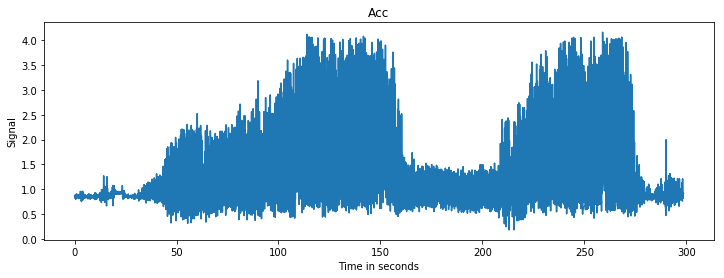

In [5]:
# plot for the accelerometer magnitude from the individual channels
acc = np.sqrt(accx**2 + accy**2 + accz**2)
plt.figure(figsize=(12, 4))
plt.plot(ts,acc)
plt.xlabel("Time in seconds")
plt.ylabel("Signal")
plt.title("Acc")

### Fourier Transforms of the signals to view the max frequency components

/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'Magnitude')

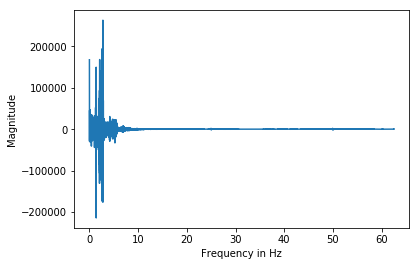

In [6]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft = np.fft.rfft(ppg)
plt.plot(freqs,fft)
plt.xlabel("Frequency in Hz")
plt.ylabel("Magnitude")


### Bandpassing the signals to select the frequencies more than 40Hz and less than 240Hz and the plots

In [7]:
ppg_bp=BandpassFilter(ppg,fs)
accx_bp=BandpassFilter(accx,fs)
accy_bp=BandpassFilter(accy,fs)
accz_bp=BandpassFilter(accz,fs)
acc_bp=BandpassFilter(acc,fs)

In [8]:
#import mpld3


Text(0.5,1,'ACC_X')

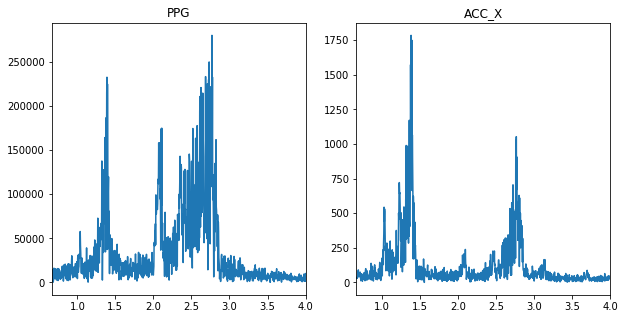

In [9]:
ppg_fft = np.abs(np.fft.rfft(ppg_bp))
accx_fft = np.abs(np.fft.rfft(accx_bp))
accy_fft = np.abs(np.fft.rfft(accy_bp))
accz_fft = np.abs(np.fft.rfft(accz_bp))
acc_fft = np.abs(np.fft.rfft(acc_bp))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(freqs,ppg_fft)
plt.xlim(40/60,240/60)
plt.title("PPG")
plt.subplot(1,2,2)
plt.plot(freqs,accx_fft)
plt.xlim(40/60,240/60)
plt.title("ACC_X")

In [10]:
#mpld3.enable_notebook()

Text(0.5,1,'ACC')

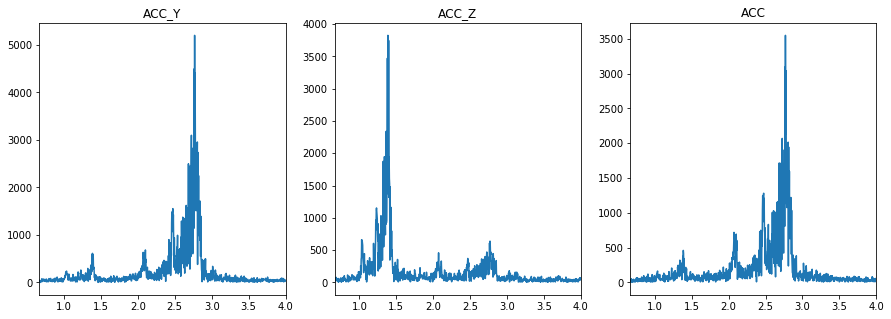

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(freqs,accy_fft)
plt.xlim(40/60,240/60)
plt.title("ACC_Y")
plt.subplot(1,3,2)
plt.plot(freqs,accz_fft)
plt.xlim(40/60,240/60)
plt.title("ACC_Z")
plt.subplot(1,3,3)
plt.plot(freqs,acc_fft)
plt.xlim(40/60,240/60)
plt.title("ACC")

As can be see from the plots above, ther are a number of frquency components in the ppg signal as the heart rate changes thruought he duration of 5mins

### Spectrograms of the signals

Text(0.5,1,'Acc_y')

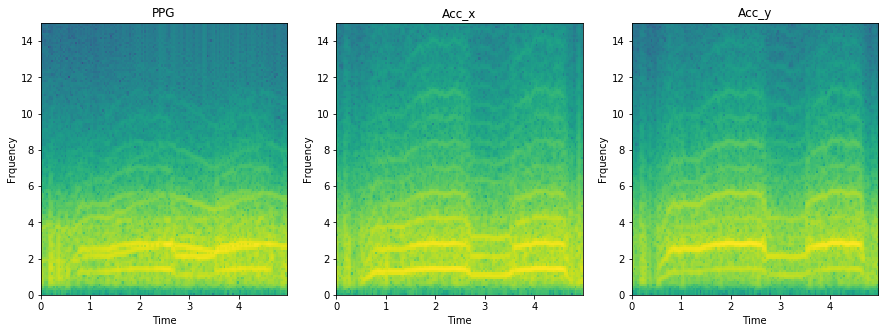

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
spec,freq,_,_= plt.specgram(ppg_bp,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(ppg_bp)/60/fs])
plt.ylim(0,15)
plt.xlabel("Time")
plt.ylabel("Frquency")
plt.title("PPG")
plt.subplot(1,3,2)
spec,freq,_,_= plt.specgram(accx_bp,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(accx_bp)/60/fs])
plt.ylim(0,15)
plt.xlabel("Time")
plt.ylabel("Frquency")
plt.title("Acc_x")
plt.subplot(1,3,3)
spec,freq,_,_= plt.specgram(accy_bp,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(accy_bp)/60/fs])
plt.ylim(0,15)
plt.xlabel("Time")
plt.ylabel("Frquency")
plt.title("Acc_y")

Text(0.5,1,'Acc')

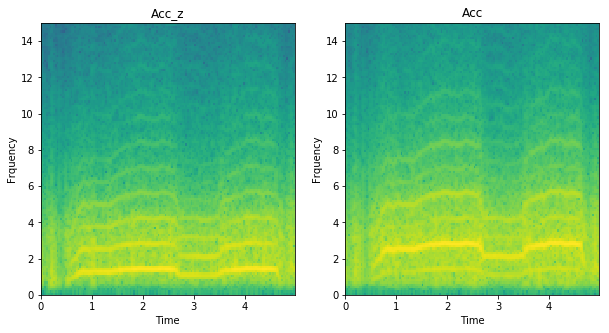

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
spec,freq,_,_= plt.specgram(accz_bp,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(accz_bp)/60/fs])
plt.ylim(0,15)
plt.xlabel("Time")
plt.ylabel("Frquency")
plt.title("Acc_z")
plt.subplot(1,2,2)
spec,freq,_,_= plt.specgram(acc_bp,Fs=fs,NFFT=fs*8,noverlap=6*fs,xextent=[0,len(acc_bp)/60/fs])
plt.ylim(0,15)
plt.xlabel("Time")
plt.ylabel("Frquency")
plt.title("Acc")

In [132]:
def RunPulseRateAlgorithm(data_fl, ref_fl,ii):
    """
    The algorithm takes as inputs from the training data and output the heart rate for every set of ppg, accelerometer data.
    The algorithm sorts the frquencies of the ppg signal in every 8 sec window (6 sec overlap) and compares the max frequencies
    to those from the accelerometer data.
    The alogrithm keeps track of the recent most heartrate value and smoothens the next value to be added to a small extent to 
    ensure that ther are no big jumps.
    
    Args:
        data_fl: data set containing the ppg, accelerometer values for x,y,z, dimensions
        ref_fl: reference heart rate in BPM
    Returns:
        errors: np array of errors for heart rate estimations
        confidence: np array of confidence values for the heart rate estimations
    
    """
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # Compute pulse rate estimates and estimation confidence.
    fs = 125
    t= len(ppg)/fs
    ts=np.arange(0,t,1/fs)
          
    #bandpass filter 40-240bpm
    ppg_bp=BandpassFilter(ppg,fs)
    accx_bp=BandpassFilter(accx,fs)
    accy_bp=BandpassFilter(accy,fs)
    accz_bp=BandpassFilter(accz,fs)
    acc_bp=BandpassFilter(acc,fs)
       
    #----spectrogram of the ppg and accelerometer signals ---------------#
    spec_ppg,freq_ppg=spectrogram(ppg_bp,fs) # spec_ppg.shape=(501,148) , freq_ppg.shape=148
    spec_accx,freq_accx=spectrogram(accx_bp,fs)
    spec_accy,freq_accy=spectrogram(accy_bp,fs)
    spec_accz,freq_accz=spectrogram(accy_bp,fs)
    spec_acc,freq_accz=spectrogram(acc_bp,fs)
    
    #----select the desired frequency ranges from the spectrogram ---------------#
    freq_use = (freq_ppg> 40/60) & (freq_ppg < 240/60)
    
    spec_ppg[~freq_use]=0.0
    spec_accx[~freq_use]=0.0
    spec_accy[~freq_use]=0.0
    spec_accz[~freq_use]=0.0
    spec_acc[~freq_use]=0.0
    
    #----sort the frequencies in descending order of signal strength ---------------#
    sorted_ppg=(-spec_ppg).argsort(axis=0)
    sorted_accx=(-spec_accx).argsort(axis=0)
    sorted_accy=(-spec_accy).argsort(axis=0)
    sorted_accz=(-spec_accz).argsort(axis=0)
    sorted_acc=(-spec_acc).argsort(axis=0)
    
     
    #print(spec_ppg.shape) # 501,148
    #print(freq_ok_ppg[sorted_ppg[0][1]]) # sorted array contains column wise indices max to min for column
 
    fi, confidence=[], []
    k=2 #select top 2 frequencies based on strength
    prev=freq_ppg[sorted_ppg[0][0]]
 
    for i in range(0,sorted_ppg.shape[1]):
   
        max_ppgs= freq_ppg[sorted_ppg[0:k,i]]
        max_accx= freq_accx[sorted_accx[0][i]]
        max_accy= freq_accy[sorted_accy[0][i]]
        max_accz= freq_accz[sorted_accz[0][i]]
        max_acc= freq_accz[sorted_acc[0][i]]
             
        idx = np.argsort(np.abs(max_ppgs - prev))
        val=prev
       
        for f in max_ppgs[idx]:
            if  (f == max_accz) or (f == max_accy) or (f==max_accx) :  
                continue
            else: 
                n=int((f-prev)/0.25)
                if abs(n)>=1:
                      val=prev + math.floor(n/2)*0.125  # smoothening the values since heart rate values always increase gradually
                    
                else:
                    val=f
                break
        
        fi.append(val)     
        # confidence 
        sig=spec_ppg.T[i][freq_ppg==val] # strength at the selected frequency in a particular window
        sigt=np.sum(spec_ppg.T[i]) # total strength of all frquencies in that window
        conf = sig/sigt
        confidence.append(conf[0])
        
        if i>3:
            prev=np.min(fi[-3])
    #------------------
    
    hr=[x*60 for x in fi]
    ref_data=sp.io.loadmat(ref_fl)['BPM0']
    errors=np.abs(hr-np.squeeze(ref_data))
    
    #debugging to view the plot of the  estimated and target heartrate
    #if ii==11:
     #   plt.plot(hr)
     #   plt.plot(np.squeeze(ref_data))
     #   plt.plot(np.diff(np.squeeze(ref_data)))
      
    print (np.mean(errors))
       
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, np.array(confidence)

8.03110754098
11.5254684815
8.37109857143
13.3126168224
7.88801506849
4.73454794521
31.0317726667
22.7984323771
7.221030625
31.0111778523
13.224713986
43.2644452055


15.29060229655189

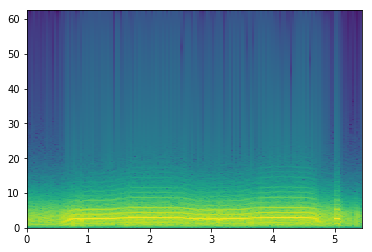

In [133]:
Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

**Code Description**  
The project/code takes as inputs ppg and accelerometer signal values on the x,y,z channels and attempts to predict the correct heartrate values from the ppg channel data. Unfortuantely the ppg data (signal information) is influenced by a person's hand (wearing the device) movement as captured by the accelerometer. 
The task is therefore to isolate the actual heart reate values in the ppg signal by taking help of the accelerometer values.

To execute this project - one can "Run All cells"
mpld3 needs to installed for making the plots interactive.

**Data Description**  
From the Fourier transforms and spectrograms plotted above, we can infer that 
1. ppg - frequencies with max intensity-  1.4hz and ~2.8Hz. one main signal and the other is its Harmonic
2. Same for the signal on the x,y,z channel.
3. However, the FFT of the accelerometer magnitute looks different, with different frequencies. The strong frquencies are centered around 2.5Hz
4. A larger dataset with a variety of ppg and accelerometer signals will help generalise the algorithm better. Currently the training is limited to the small dataset.

**Algorithm Description**  
The algorithm does the following :
1. Since we know that a human heart beats in the range 40 to max 240Hz, we can take advantage of this fact and filter all  the signals.
2. The signal is split into 8 sec windows with 6 sec overlap.
3. Next we sort each of the signals based on the max frequency from highest to lowest for each window
4. We then compare the peaks of the signals. If the ppg signal max frequency is same as the max fequency for the acc_y or acc_z, we consider this peak in the ppg to be attributed to the persons movement. We skip this max ppg frequency and look for the next frequency. We look at the top 2 frequencies for each window.
5. An aspect of the human body that is also exploited in this algorithm is that the heart rate doesn't change by large values. it always increases gradually. We use this inforation while selecting the max ppg signal. we select one that is closest to the last 3 previous heartrate value.
6. The confidence algorithm has a higher number for better estimates. Intuitively, thats because we are looking at the signal strength for the selected strength, divided by the total signal strength of all signals for every window. And for correct estiamtes, the signal strength for the selected signal will be high.
7. From the observations above (commented debug prints) it's seen that the algorithm doesn't work well when a person has a steep increase in heart rate. 

**Algorithm Performance** 
1. The performance of the algorithm was tested on a test set, initally unknown to the algorithm. The algorithm was trained on a separate training data - 12 in count.
2. The algorithm outputs a value for the heart rate every 2 seconds. 
3. The loss function or the metric used is the mean absolute error between the predicted heart rate and the real heart rate for each 8 second window( 6 sec overlap)
4. The algorithm looks at the top 2 max frequencies. 
5. The error in the train set is 15.29 and the error on the test set is < 5BPM . 
6. Most of the samples are from people who had a gradual increase during the exercise. The algorithm doesnt generalise to this type of input.This can be fine tuned by futher breaking down the frequency space and checking for the case of a steep increase in heartrate.


-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 